![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# PCA - Tarefa 01: *HAR* com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
filename_features = "~/Desktop/UCI HAR Dataset/features.txt"
filename_labels = "~/Desktop/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "~/Desktop/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "~/Desktop/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "~/Desktop/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "~/Desktop/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "~/Desktop/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "~/Desktop/UCI HAR Dataset/test/y_test.txt"

# Reading data
# Remove `squeeze=True` and use `.iloc` to extract the Series.
features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")['nome_var']
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])['subject_id']
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None)
y_train = pd.read_csv(filename_ytrain, header=None, names=['activity_id'])['activity_id']

# Test data
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None)
y_test = pd.read_csv(filename_ytest, header=None, names=['activity_id'])['activity_id']


/tmp/ipykernel_7088/863137963.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])
/tmp/ipykernel_7088/863137963.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None)
/tmp/ipykernel_7088/863137963.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None)


A base original vem dividdida em treino e testes. Vamos dividir a base de treino em Treino e Validação, para podermos fazer o post-prunning da nossa árvore - e avaliar o modelo final em uma base de testes isenta.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

## Árvore de decisão

Rode uma árvore de decisão com todas as variáveis, utilizando o ```ccp_alpha=0.001```. Avalie a acurácia nas bases de treinamento e teste. Avalie o tempo de processamento.

In [5]:
%%time
import numpy as np

clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(X_train, y_train)
caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

CPU times: user 2min 33s, sys: 1.29 ms, total: 2min 33s
Wall time: 2min 33s


## Árvore com PCA

Faça uma análise de componemtes principais das variáveis originais. Utilize apenas uma componente. Faça uma árvore de decisão com esta componente como variável explicativa.

- Avalie a acurácia nas bases de treinamento e teste
- Avalie o tempo de processamento

In [7]:
%%time

prcomp = PCA(n_components=1).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_valida = prcomp.transform(X_valid)
pc_teste  = prcomp.transform(X_test)

pc_treino.shape

CPU times: user 3.16 s, sys: 8.99 ms, total: 3.17 s
Wall time: 218 ms


(5514, 1)

In [11]:
n=1

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_valid = pd.DataFrame(pc_valida[:,:n], columns = colunas)
pc_test  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head()

,cp1
0,-5.396791
1,8.416578
2,-3.111766
3,7.149643
4,-2.153767


In [12]:
%%time
clf_pca = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_train, y_train)

CPU times: user 22.7 ms, sys: 1e+03 ns, total: 22.7 ms
Wall time: 22.4 ms


In [16]:
print(clf_pca.score(pc_valid, y_valid))
print(clf_pca.score(pc_test, y_test))
print(clf_pca.score(pc_train, y_train))

0.4809575625680087
0.45266372582287073
0.5027203482045702


## Testando o número de componentes

Com base no código acima, teste a árvore de classificação com pelo menos as seguintes possibilidades de quantidades de componentes: ```[1, 2, 5, 10, 50]```. Avalie para cada uma delas:

- Acurácia nas bases de treino e teste
- Tempo de processamento


In [21]:
%%time

prcomp = PCA().fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste = prcomp.transform(X_test)

CPU times: user 4.28 s, sys: 17 ms, total: 4.3 s
Wall time: 304 ms


In [24]:
lista = [1, 2, 5, 10, 50]
score_train = []
score_test = []

for n in lista:
    colunas = ['cp'+str(x+1) for x in list(range(n))]

    pc_train = pd.DataFrame(pc_treino[:, :n], columns=colunas)
    pc_test = pd.DataFrame(pc_teste[:, :n], columns=colunas)

    clf = DecisionTreeClassifier(random_state=100, ccp_alpha=0.001).fit(pc_train, y_train)

    s_tr = clf.score(pc_train, y_train)
    score_train.append(s_tr)

    s_te = clf.score(pc_test, y_test)
    score_test.append(s_te)

In [26]:
resultados = {'quantidade_componentes': lista, 'score_treino': score_train, 'score_teste': score_test}

df = pd.DataFrame(resultados)
df

,quantidade_componentes,score_treino,score_teste
0,1,0.502720,0.452664
1,2,0.624592,0.559552
2,5,0.852194,0.784866
3,10,0.899347,0.818120
4,50,0.941240,0.799796


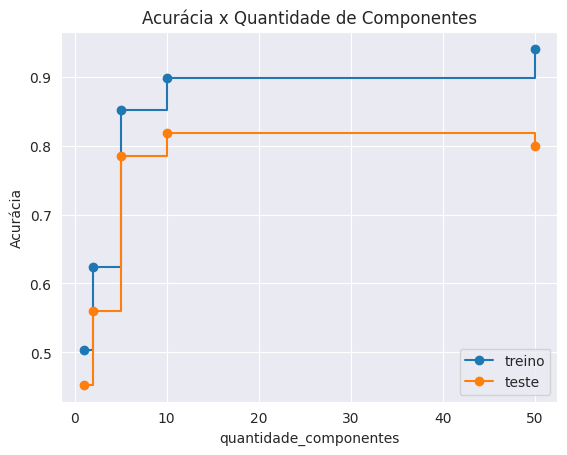

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_xlabel("quantidade_componentes")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x Quantidade de Componentes")
ax.plot(df['quantidade_componentes'], df['score_treino'], marker='o', label="treino", drawstyle="steps-post")
ax.plot(df['quantidade_componentes'], df['score_teste'], marker='o', label="teste", drawstyle="steps-post")

ax.legend()
plt.show()

In [29]:
%%time

n = 10

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:, :n], columns=colunas)
pc_test = pd.DataFrame(pc_teste[:, :n], columns=colunas)

clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_train, y_train)


CPU times: user 58.2 ms, sys: 0 ns, total: 58.2 ms
Wall time: 57.4 ms


## Conclua

- O que aconteceu com a acurácia?
- O que aconteceu com o tempo de processamento?

questao 1

A acurácia do modelo melhora com o aumento da quantidade de componentes até um certo ponto.
Após esse ponto, a acurácia do conjunto de teste se estabiliza ou diminui, indicando overfitting.
A quantidade ideal de componentes parece ser por volta de 10, onde o modelo atinge um bom equilíbrio entre desempenho no treino e no teste.

questao 2

o tempo teve uma melhora em relacao ao tempo anterio que foi
de 4.3 minutos ja nesse tempo chegou a 58.2 segundo